# LR2

In [3]:
!pip install pmdarima

# Анализ временного ряда цен актива

В этом документе представлен код для анализа временного ряда цен актива с использованием Python. Мы будем использовать библиотеки `pandas`, `numpy`, `matplotlib`, `statsmodels`, `pmdarima` и `sklearn`.

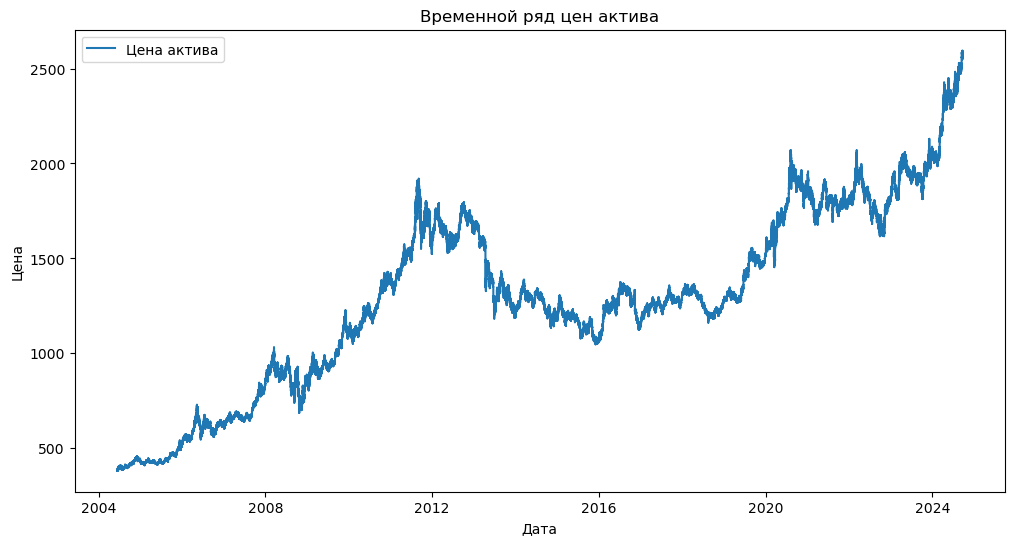

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Загрузка данных
data = pd.read_csv('XAU_15m_data_2004_to_2024-20-09.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# 2. Построение графика
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Цена актива')
plt.title('Временной ряд цен актива')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.show()


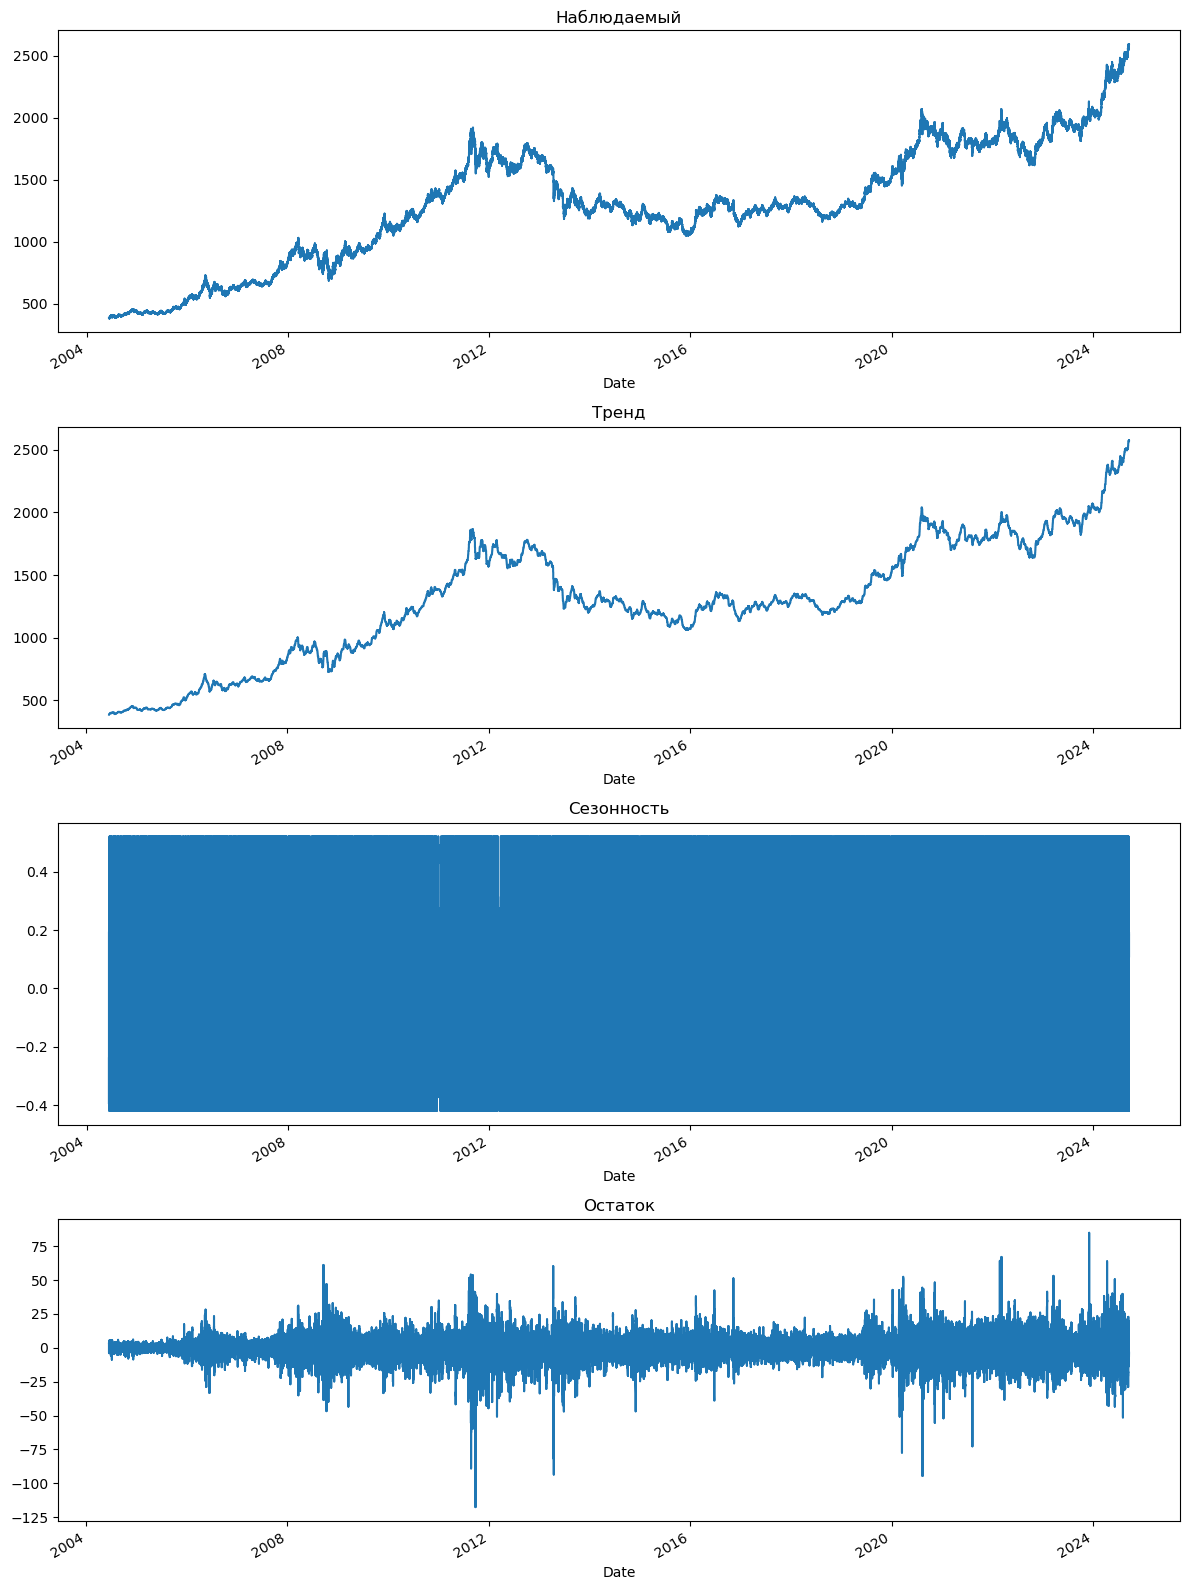

In [2]:
# 3. Декомпозиция временного ряда
decomposition = seasonal_decompose(data['Close'], model='additive', period=365)  # Период можно изменить в зависимости от частоты данных
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Наблюдаемый')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Тренд')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Сезонность')
decomposition.resid.plot(ax=ax4)
ax4.set_title('Остаток')
plt.tight_layout()
plt.show()

In [3]:
# 4. Тест на стационарность (тест Дики-Фуллера)
def adf_test(series):
    result = adfuller(series.dropna(), autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')

adf_test(data['Close'])

# 5. Если ряд нестационарен, приведем его к стационарному виду (разностное преобразование)
data_diff = data['Close'].diff().dropna()

ADF Statistic: -0.2736518744847209
p-value: 0.9291540057221286


In [4]:
# 6. Построение и сравнение моделей ARIMA с auto_arima для подбора параметров
train_size = int(len(data_diff) * 0.8)
train, test = data_diff[:train_size], data_diff[train_size:]

model = auto_arima(train, seasonal=False, stepwise=True)
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               371788
Model:               SARIMAX(0, 0, 1)   Log Likelihood             -648986.354
Date:                Tue, 22 Oct 2024   AIC                        1297978.708
Time:                        12:55:19   BIC                        1298011.187
Sample:                             0   HQIC                       1297988.017
                             - 371788                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0042      0.002      1.852      0.064      -0.000       0.009
ma.L1         -0.0163      0.001    -24.898      0.000      -0.018      -0.015
sigma2         1.9218      0.001   1939.904      0.0

D:\Programs\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
D:\Programs\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


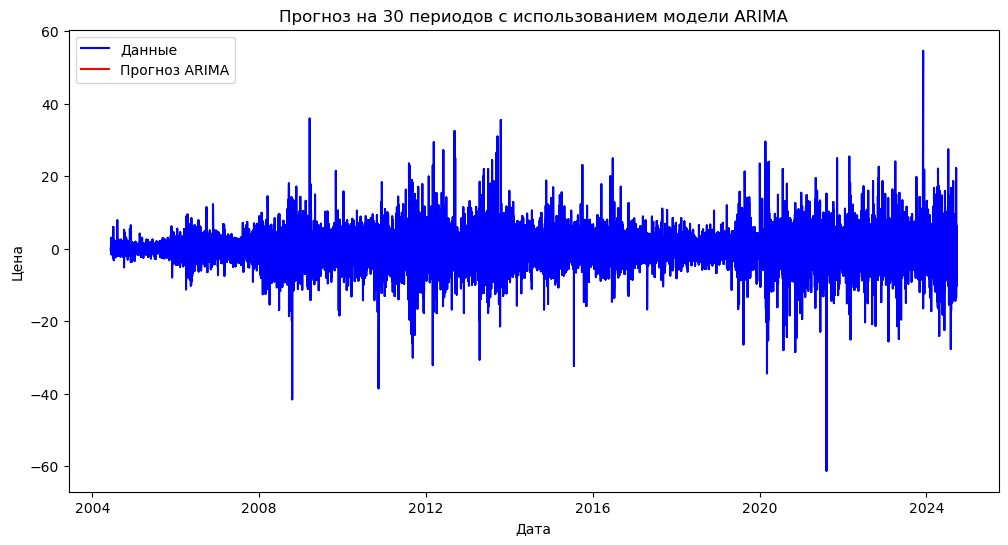

In [5]:
# 7. Прогнозирование с использованием лучшей модели ARIMA
forecast_best = model.predict(n_periods=30)

# Визуализация прогноза для лучшей модели
forecast_index_best = pd.date_range(start=data_diff.index[-1] + pd.Timedelta(minutes=15), periods=30, freq='15T')
forecast_series_best = pd.Series(forecast_best, index=forecast_index_best)

plt.figure(figsize=(12, 6))
plt.plot(data.index[:len(data_diff)], data_diff.values[:len(data_diff)], label='Данные', color='blue')
plt.plot(forecast_series_best.index, forecast_series_best.values + data['Close'].iloc[-1], label='Прогноз ARIMA', color='red') # Добавляем последнее значение для корректной визуализации уровня цен
plt.title('Прогноз на 30 периодов с использованием модели ARIMA')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.show()

### Заключение
В данном анализе мы рассмотрели процесс работы с временными рядами цен актива. Мы использовали декомпозицию для выявления тренда и сезонности, а также модель ARIMA для прогнозирования будущих значений.